ValueError: 'touchstart_event' is not a valid value for signal; supported values are 'resize_event', 'draw_event', 'key_press_event', 'key_release_event', 'button_press_event', 'button_release_event', 'scroll_event', 'motion_notify_event', 'pick_event', 'figure_enter_event', 'figure_leave_event', 'axes_enter_event', 'axes_leave_event', 'close_event'

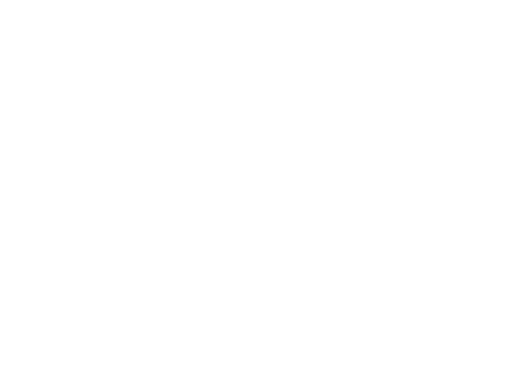

In [1]:
# Import the module or specific elements from it
from mobile_game import N_Queens_Game

# Create an instance of the game
game_instance = N_Queens_Game()

# Call methods or use attributes of the instance
game_instance.setup_ui()
